#**ARIMA Model Predictions**
  By Lucas (Deuce) Palmer

In [ ]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 4.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from pmdarima.arima.utils import ndiffs

from pmdarima.arima import auto_arima

from math import sqrt
import itertools
import warnings
warnings.filterwarnings("ignore")

# 1st Stock: Microsoft Corp, MSFT


Download the data for the 3 time periods: 6-months, 1-year, 2-years from Yahoo Finance.

In [ ]:
df_6mo = yf.download('MSFT', start='2023-10-01', end='2024-03-31')
df_1yr = yf.download('MSFT', start='2023-03-31', end='2024-03-31')
df_2yr = yf.download('MSFT', start='2022-03-31', end='2024-03-31')

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Collect only the daily close price from the Pandas Dataframe.
Split the data for each time period into training data (80%) and test data (20%)

In [ ]:
close_6mo = df_6mo["Close"]
train_6mo = close_6mo[:int(len(close_6mo) * 0.8)]
test_6mo = close_6mo[int(len(close_6mo) * 0.8):]

close_1yr = df_1yr["Close"]
train_1yr = close_1yr[:int(len(close_1yr) * 0.8)]
test_1yr = close_1yr[int(len(close_1yr) * 0.8):]

close_2yr = df_2yr["Close"]
train_2yr = close_2yr[:int(len(close_2yr) * 0.8)]
test_2yr = close_2yr[int(len(close_2yr) * 0.8):]

Find the necessary order of differencing in order to make the series stationary

In [ ]:
# Sanity Check
# result = adfuller(close_2yr.diff().dropna()) # close_6mo.diff().dropna(), close_1yr.diff().dropna()
# print('ADF Statistic: %f' % result[0])
# print('p-value: %f' % result[1])

print("d for 6 months: ", ndiffs(close_6mo, test="adf"))
print("d for 1 Year: ", ndiffs(close_1yr, test="adf"))
print("d for 2 Years: ", ndiffs(close_2yr, test="adf"))

d for 6 months:  1
d for 1 Year:  1
d for 2 Years:  1


Use pmdarima's auto_arima function to optimize the lag values

In [ ]:
model = auto_arima(train_6mo, seasonal=False, trace=True)
print(model.summary())

model = auto_arima(train_1yr, seasonal=False, trace=True)
print(model.summary())

model = auto_arima(train_2yr, seasonal=False, trace=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=577.509, Time=0.60 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=578.987, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=573.999, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=574.155, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=580.891, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=575.676, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=575.828, Time=0.32 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=577.157, Time=0.73 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=578.413, Time=0.07 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 2.210 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   99
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -283.999
Date:                Tue, 30 Apr 2024   AIC               

Fit the model's given the optimal values from above

In [ ]:
model = ARIMA(train_6mo, order=(1, 1, 0))
best_model_6mo = model.fit()
print("AIC: ", best_model_6mo.aic)
print("BIC: ", best_model_6mo.bic)

model = ARIMA(train_1yr, order=(0, 1, 1))
best_model_1yr = model.fit()
print("AIC: ", best_model_1yr.aic)
print("BIC: ", best_model_1yr.bic)

model = ARIMA(train_2yr, order=(2, 1, 2))
best_model_2yr = model.fit()
print("AIC: ", best_model_2yr.aic)
print("BIC: ", best_model_2yr.bic)

AIC:  578.4132318084673
BIC:  583.5831667658085
AIC:  1182.7632281845417
BIC:  1189.3498378339907
AIC:  2471.9985957585377
BIC:  2491.943402842987


Calculate the Root Mean-Square Error (RMSE) on the unseen data points in a rolling fashion

In [ ]:
pred_6mo = []
actual_6mo = []
for i in range(len(test_6mo)):
    pred = best_model_6mo.forecast(steps=1)
    pred_6mo.append(pred)
    actual_6mo.append(test_6mo[i])
    best_model_6mo = ARIMA(np.append(train_6mo, test_6mo[i]), order=(1, 1, 0)).fit()
rmse_6mo = sqrt(mean_squared_error(actual_6mo, pred_6mo))
print("RMSE (6 Months): ", rmse_6mo)

pred_1yr = []
actual_1yr = []
for i in range(len(test_1yr)):
    pred = best_model_1yr.forecast(steps=1)
    pred_1yr.append(pred)
    actual_1yr.append(test_1yr[i])
    best_model_1yr = ARIMA(np.append(train_1yr, test_1yr[i]), order=(0, 1, 1)).fit()
rmse_1yr = sqrt(mean_squared_error(actual_1yr, pred_1yr))
print("RMSE (1 Year): ", rmse_1yr)

pred_2yr = []
actual_2yr = []
for i in range(len(test_2yr)):
    pred = best_model_2yr.forecast(steps=1)
    pred_2yr.append(pred)
    actual_2yr.append(test_2yr[i])
    best_model_2yr = ARIMA(np.append(train_2yr, test_2yr[i]), order=(2, 1, 2)).fit()
rmse_2yr = sqrt(mean_squared_error(actual_2yr, pred_2yr))
print("RMSE (2 Years): ", rmse_2yr)

RMSE (6 Months):  4.849113406330878
RMSE (1 Year):  5.645231037583001
RMSE (2 Years):  4.992038476995593


Plot the training closing prices (blue), test closing prices (orange), and the model's predictions (green)

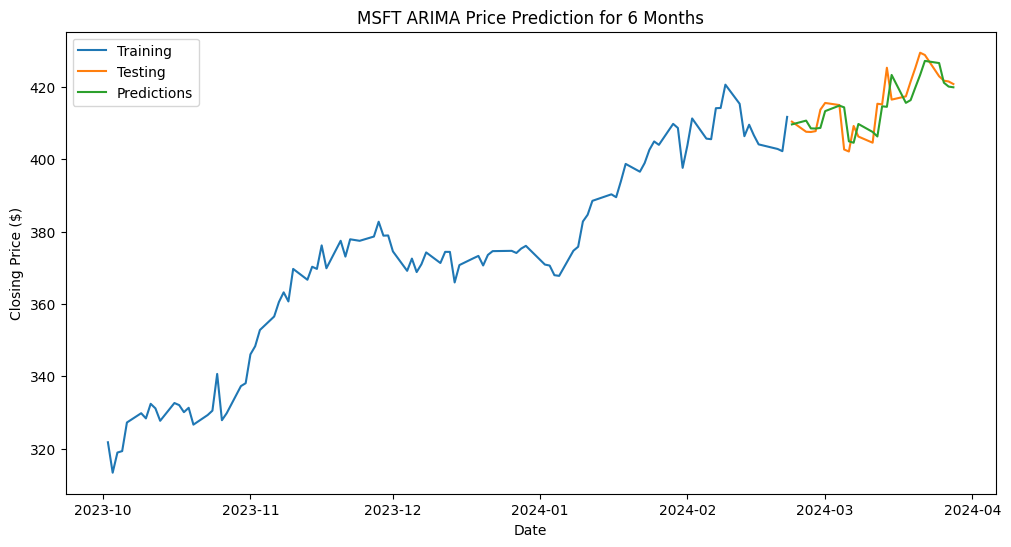

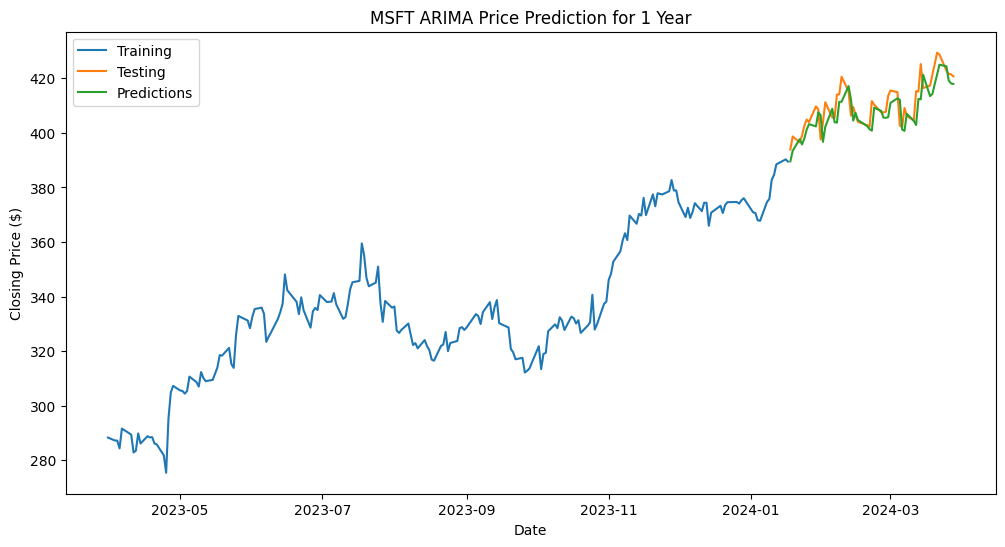

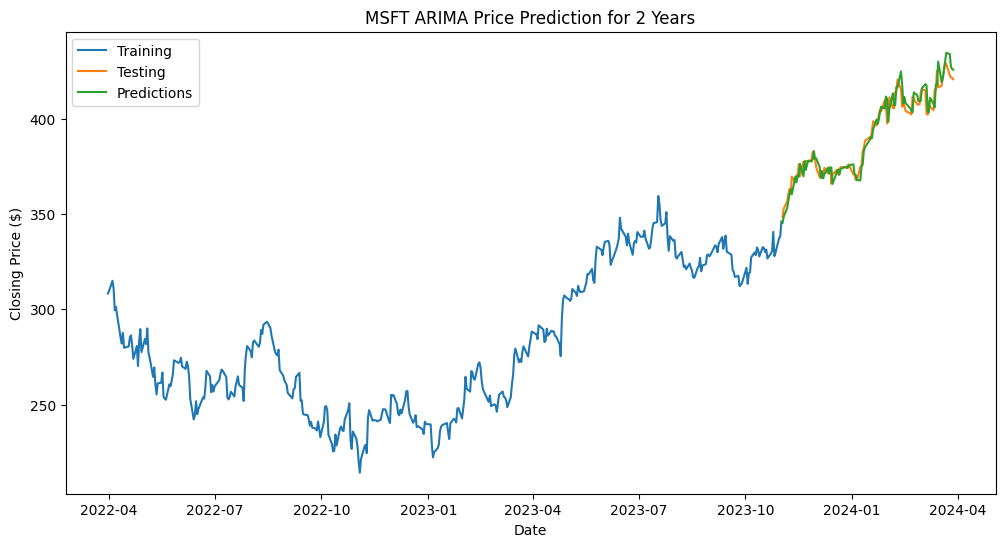

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(train_6mo, label="Training")
plt.plot(test_6mo, label="Testing")
plt.plot(test_6mo.index, pred_6mo, label="Predictions")
plt.xlabel("Date")
plt.ylabel("Closing Price ($)")
plt.title("MSFT ARIMA Price Prediction for 6 Months")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(train_1yr, label="Training")
plt.plot(test_1yr, label="Testing")
plt.plot(test_1yr.index, pred_1yr, label="Predictions")
plt.xlabel("Date")
plt.ylabel("Closing Price ($)")
plt.title("MSFT ARIMA Price Prediction for 1 Year")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(train_2yr, label="Training")
plt.plot(test_2yr, label="Testing")
plt.plot(test_2yr.index, pred_2yr, label="Predictions")
plt.xlabel("Date")
plt.ylabel("Closing Price ($)")
plt.title("MSFT ARIMA Price Prediction for 2 Years")
plt.legend()
plt.show()

# 2nd Stock: China Evergrande Group, EGRNQ



Download the data for the 3 time periods: 6-months, 1-year, 2-years from Yahoo Finance.

In [ ]:
df_6mo = yf.download('EGRNQ', start='2023-10-01', end='2024-03-31')
df_1yr = yf.download('EGRNQ', start='2023-03-31', end='2024-03-31')
df_2yr = yf.download('EGRNQ', start='2022-03-31', end='2024-03-31')

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Collect only the daily close price from the Pandas Dataframe.
Split the data for each time period into training data (80%) and test data (20%)

In [ ]:
close_6mo = df_6mo["Close"]
train_6mo = close_6mo[:int(len(close_6mo) * 0.8)]
test_6mo = close_6mo[int(len(close_6mo) * 0.8):]

close_1yr = df_1yr["Close"]
train_1yr = close_1yr[:int(len(close_1yr) * 0.8)]
test_1yr = close_1yr[int(len(close_1yr) * 0.8):]

close_2yr = df_2yr["Close"]
train_2yr = close_2yr[:int(len(close_2yr) * 0.8)]
test_2yr = close_2yr[int(len(close_2yr) * 0.8):]

Find the necessary order of differencing in order to make the series stationary

In [ ]:
print("d for 6 months: ", ndiffs(close_6mo, test="adf"))
print("d for 1 Year: ", ndiffs(close_1yr, test="adf"))
print("d for 2 Years: ", ndiffs(close_2yr, test="adf"))

d for 6 months:  1
d for 1 Year:  0
d for 2 Years:  1


Use pmdarima's auto_arima function to optimize the lag values

In [ ]:
model = auto_arima(train_6mo, seasonal=False, trace=True)
print(model.summary())

model = auto_arima(train_1yr, seasonal=False, trace=True)
print(model.summary())

model = auto_arima(train_2yr, seasonal=False, trace=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-542.646, Time=0.86 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-527.453, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-526.458, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-531.222, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-529.438, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-545.262, Time=0.60 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-547.212, Time=1.07 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-545.210, Time=0.38 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-541.050, Time=0.36 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-543.156, Time=0.25 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-549.015, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-533.154, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-547.072, Time=0.32 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-547.015, Time=0.22 sec
 ARIMA(1,1,1)(0,0,0)[0]          

Fit the model's given the optimal values from above

In [ ]:
model = ARIMA(train_6mo, order=(0, 1, 2))
best_model_6mo = model.fit()
print("AIC: ", best_model_6mo.aic)
print("BIC: ", best_model_6mo.bic)

model = ARIMA(train_1yr, order=(3, 1, 1))
best_model_1yr = model.fit()
print("AIC: ", best_model_1yr.aic)
print("BIC: ", best_model_1yr.bic)

model = ARIMA(train_2yr, order=(3, 1, 2))
best_model_2yr = model.fit()
print("AIC: ", best_model_2yr.aic)
print("BIC: ", best_model_2yr.bic)

AIC:  -549.0149945410433
BIC:  -541.2600921050316
AIC:  -1133.7307850195666
BIC:  -1117.264260895944
AIC:  -2195.7006659200406
BIC:  -2171.7668974187013


Calculate the Root Mean-Square Error (RMSE) on the unseen data points in a rolling fashion

In [ ]:
pred_6mo = []
actual_6mo = []
for i in range(len(test_6mo)):
    pred = best_model_6mo.forecast(steps=1)
    pred_6mo.append(pred)
    actual_6mo.append(test_6mo[i])
    best_model_6mo = ARIMA(np.append(train_6mo, test_6mo[i]), order=(0, 1, 2)).fit()
rmse_6mo = sqrt(mean_squared_error(actual_6mo, pred_6mo))
print("RMSE (6 Months): ", rmse_6mo)

pred_1yr = []
actual_1yr = []
for i in range(len(test_1yr)):
    pred = best_model_1yr.forecast(steps=1)
    pred_1yr.append(pred)
    actual_1yr.append(test_1yr[i])
    best_model_1yr = ARIMA(np.append(train_1yr, test_1yr[i]), order=(3, 1, 1)).fit()
rmse_1yr = sqrt(mean_squared_error(actual_1yr, pred_1yr))
print("RMSE (1 Year): ", rmse_1yr)

pred_2yr = []
actual_2yr = []
for i in range(len(test_2yr)):
    pred = best_model_2yr.forecast(steps=1)
    pred_2yr.append(pred)
    actual_2yr.append(test_2yr[i])
    best_model_2yr = ARIMA(np.append(train_2yr, test_2yr[i]), order=(3, 1, 2)).fit()
rmse_2yr = sqrt(mean_squared_error(actual_2yr, pred_2yr))
print("RMSE (2 Years): ", rmse_2yr)

RMSE (6 Months):  0.005484850449543272
RMSE (1 Year):  0.008498421917314343
RMSE (2 Years):  0.018865278735318677


Plot the training closing prices (blue), test closing prices (orange), and the model's predictions (green)

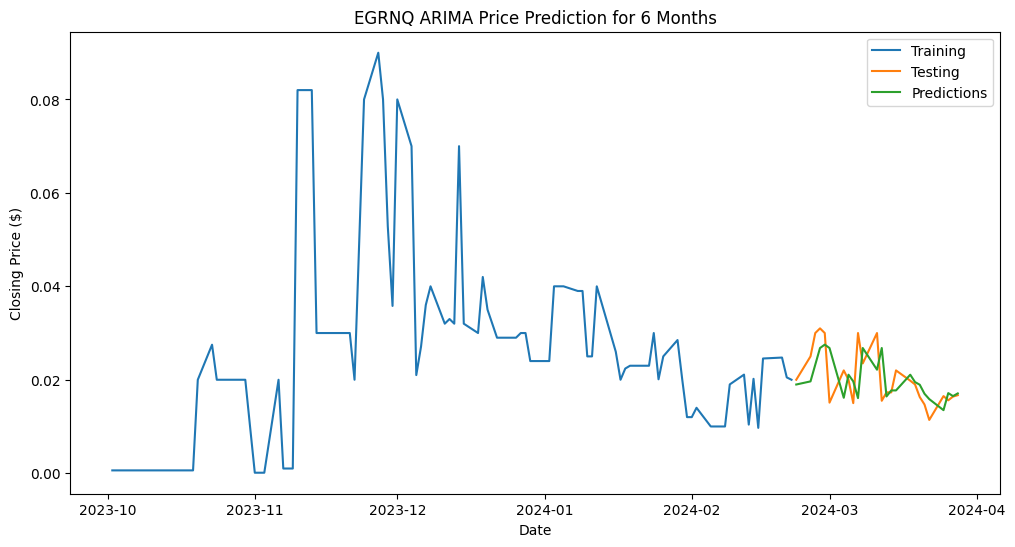

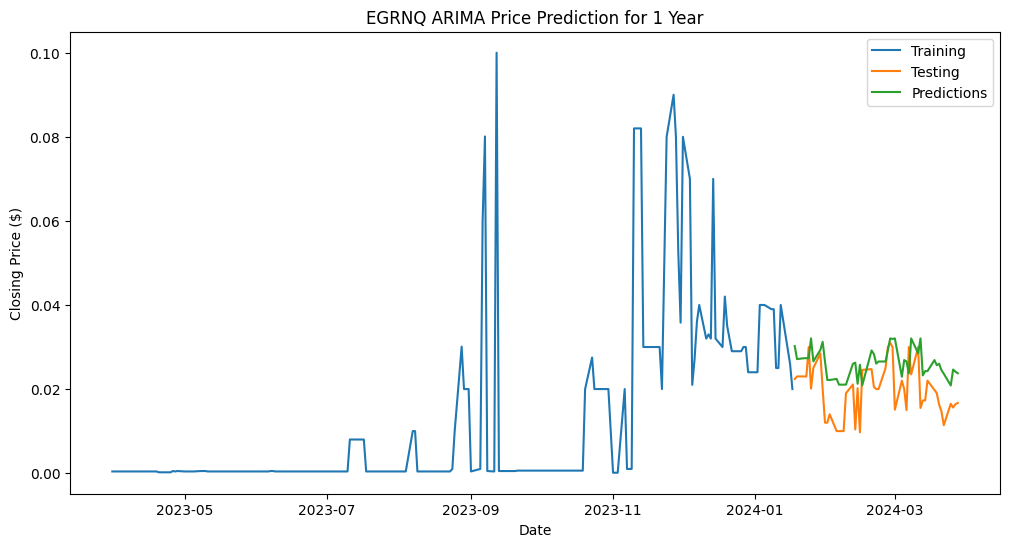

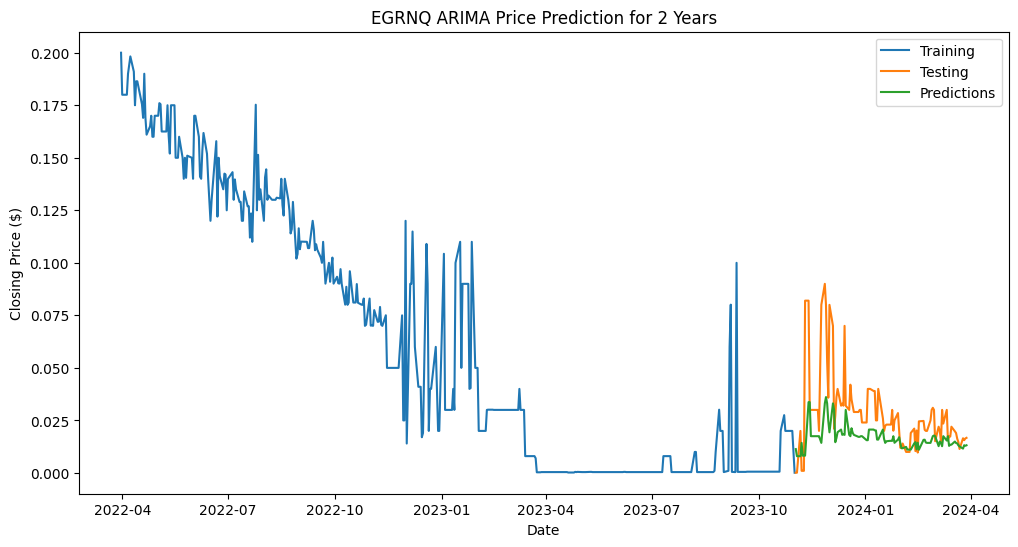

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(train_6mo, label="Training")
plt.plot(test_6mo, label="Testing")
plt.plot(test_6mo.index, pred_6mo, label="Predictions")
plt.xlabel("Date")
plt.ylabel("Closing Price ($)")
plt.title("EGRNQ ARIMA Price Prediction for 6 Months")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(train_1yr, label="Training")
plt.plot(test_1yr, label="Testing")
plt.plot(test_1yr.index, pred_1yr, label="Predictions")
plt.xlabel("Date")
plt.ylabel("Closing Price ($)")
plt.title("EGRNQ ARIMA Price Prediction for 1 Year")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(train_2yr, label="Training")
plt.plot(test_2yr, label="Testing")
plt.plot(test_2yr.index, pred_2yr, label="Predictions")
plt.xlabel("Date")
plt.ylabel("Closing Price ($)")
plt.title("EGRNQ ARIMA Price Prediction for 2 Years")
plt.legend()
plt.show()